# About This Project


project ini merupakan final project dari matakuliah pengenalan pola.

project ini mengambil tema text classification 

tema projek ini adalah sentimen analisis twitter mengenai COVID-19 di indonesia

paper rujukan yang akan dijadikan baseline pada projek ini adalah paper dari **Prastyo dkk (2020)**

[link to paper](https://e-journal.unair.ac.id/JISEBI/article/view/19624)

## Rangkuman Paper Prastyo dkk (2020)

pada penelitianya :

1. Task
    - Multiclass Classification (positive, negative, dan neutral)
    - Binary Class (positive dan negative)

2. Dataset
    - tweet mengenai covid-19 di indonesia

3. Metodology
    - Preprocessing:
        - casefolding
        - filtering (*username, urls, picture, symbols, special char, punctuation*)
        - tokenization
        - stopword removal (*stopword dari library sastrawi*)
    - Feature: 
        - TFIDF
    - Classifier:
        - Multinomial NB
        - SVM dengan normalized poly kernel
    - Evaluasi:
        - 10k cross validation
    - Metric:
        - akurasi
        - precision
        - recall
        - f-measure

4. Result
    - hasil terbaik pada binary classification pada metode svm normalized poly kernel dengan rata-rata:
        - akurasi : 82%
        - precision : 82.24%
        - recall : 82.01%
        - f-measure : 81.84%



In [ ]:
!pip install sastrawi
!pip install neattext

     |████████████████████████████████| 215kB 5.4MB/s 
     |████████████████████████████████| 92kB 4.0MB/s 


In [ ]:
# tutorial
# https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

# import libraries
import re
import math
import pandas as pd
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import neattext as nt
import neattext.functions as nfx
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load Dataset

In [ ]:
df = pd.read_excel('/content/drive/My Drive/dataset/sentiment-covid.xlsx')
df_alay = pd.read_csv('/content/drive/My Drive/dataset/new_kamusalay.csv', encoding='latin-1', header=None)

df_alay = df_alay.rename(columns={0: 'original', 1: 'replacement'})

In [ ]:
df = df[['text','sentiment']]
df

,text,sentiment
0,Yuppp Karena UTANG Pemerintah jg UTANG Bangsa ...,Negative
1,Yuks.. kawal kebijakan pemerintah jangan sampa...,Positive
2,Yukk sama-sama bahu membahu membantuu pemerint...,Positive
3,Yuk sahabat kita samasama menjaga jarak antar ...,Positive
4,Yuk sahabat kita sama sama menjaga jarak antar...,Positive
...,...,...
2264,Semoga KTT luar biasa memberikan manfaat bg In...,Neutral
2265,"1. Corona sudah menyerang di berbagai negara, ...",Negative
2266,Sudah sampai kabupaten sebelah kawan...\nMari ...,Positive
2267,Berharap pemerintah Indonesia segara menutup p...,Neutral


In [ ]:
df_alay

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15172,lg,lagi
15173,dongg,dong
15174,yaa,ya
15175,knp2,kenapa-kenapa


# Quick EDA

cek apakah ada data yang missing

In [ ]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

plot data dalam bentuk bar

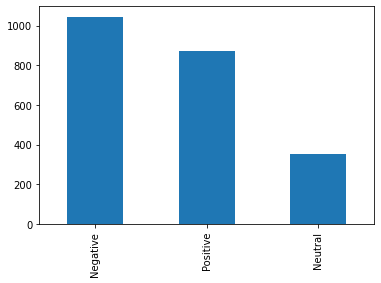

In [ ]:
df.sentiment.value_counts().plot.bar()

lihat rasio data dalam pie

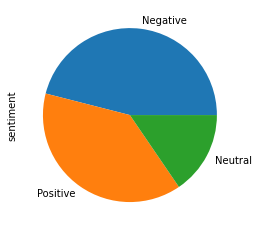

In [ ]:
df.sentiment.value_counts().plot.pie()

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# preprocessing function
def prepro(text, stem=True, alay_norm=True, stopword_ori=False):
    # lowecase
    text = text.lower()

    if alay_norm:
        # normalisasi kata alay
        alay_dict_map = dict(zip(df_alay['original'], df_alay['replacement']))
        text = ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

    # remove username
    text = nfx.remove_userhandles(text)
    # remove hastagh
    text = nfx.remove_hashtags(text)
    # remove url
    text = nfx.remove_urls(text)
    # remove spesial char
    text = nfx.remove_special_characters(text)
    # remove multiple space
    text = nfx.remove_multiple_spaces(text)
    
    # remove stopwords indonesia dan english
    # extend stopword indonesia
    a = StopWordRemoverFactory()
    if stopword_ori:
        indo_stop = a.get_stop_words()
        text = ' '.join(['' if word in indo_stop else word for word in text.split(' ')])
    else:
        indo_stop = a.get_stop_words() + ['yup','yuk','nya','ya','iya','ayo','yok','ber','nih','mah','kah','sih','dong','woy','woi','cok','bro','wow']
        eng_stop = stopwords.words('english')
        text = ' '.join(['' if word in indo_stop else word for word in text.split(' ')])
        text = ' '.join(['' if word in eng_stop else word for word in text.split(' ')])
    text = text.strip()

    if stem:
        #stemming 
        text = stemmer.stem(text)
    
    return text

In [ ]:
# cek counter 
def word_counter(text):
    count = Counter()
    for t in text.values:
        for word in t.split():
            count[word] += 1
    return count

# Our Approach


pendekatan yang kami lakukan:
1. dari dataset yang telah didapatkan, dilakukan split dengan rasio 70:30
2. preprocessing

    - casefolding
    - normalized slang word / kamus alay
    - tokenization
    - stopword removal
    - stemming

3. feature extraction

    - BOW Classic (count vectorizer)
    - BOW + TFIDF

4. classifier

    - MultinomialNB
    - SVM
    - SGD
    - Random Forest

5. 10 K-fold validation pada data training

    - evaluasi
        - akurasi

6. Hyperparameter Tuninng Classifier
7. Evaluasi data test
    - evaluasi
        - akurasi

## Prepare Dataset

In [ ]:
def generate_df(dataframe, binary=True):
    
    data = dataframe.copy()

    if binary:
        biner = data.loc[data.sentiment != 'Neutral'] 
        return biner.reset_index(drop=True)
    return data


In [ ]:
dfku = generate_df(df)

In [ ]:
dfku

,text,sentiment
0,Yuppp Karena UTANG Pemerintah jg UTANG Bangsa ...,Negative
1,Yuks.. kawal kebijakan pemerintah jangan sampa...,Positive
2,Yukk sama-sama bahu membahu membantuu pemerint...,Positive
3,Yuk sahabat kita samasama menjaga jarak antar ...,Positive
4,Yuk sahabat kita sama sama menjaga jarak antar...,Positive
...,...,...
1913,Pemerintah Pusat tetap konsisten melawan Coron...,Positive
1914,Salut sama bapak president walaupun masih suas...,Positive
1915,"1. Corona sudah menyerang di berbagai negara, ...",Negative
1916,Sudah sampai kabupaten sebelah kawan...\nMari ...,Positive


## Apply Preprocessing

In [ ]:
dfku['clean'] = dfku.text.apply(lambda x: prepro(x, stem=True, alay_norm=True, stopword_ori=False))
dfku

,text,sentiment,clean
0,Yuppp Karena UTANG Pemerintah jg UTANG Bangsa ...,Negative,utang perintah utang bangsa indonesia arti hut...
1,Yuks.. kawal kebijakan pemerintah jangan sampa...,Positive,yuks kawal bijak perintah jangan salah guna ok...
2,Yukk sama-sama bahu membahu membantuu pemerint...,Positive,samasama bahu bahu membantuu perintah putus ra...
3,Yuk sahabat kita samasama menjaga jarak antar ...,Positive,sahabat samasama jaga jarak antar manusialebih...
4,Yuk sahabat kita sama sama menjaga jarak antar...,Positive,sahabat sama sama jaga jarak antar manusia leb...
...,...,...,...
1913,Pemerintah Pusat tetap konsisten melawan Coron...,Positive,perintah pusat tetap konsisten lawan corona vi...
1914,Salut sama bapak president walaupun masih suas...,Positive,salut sama bapak presiden walaupun suasana duk...
1915,"1. Corona sudah menyerang di berbagai negara, ...",Negative,1 corona serang bagai negara perintah indonesi...
1916,Sudah sampai kabupaten sebelah kawan...\nMari ...,Positive,kabupaten belah kawanmari terap sosial distanc...


In [ ]:
# apply label encoder
le = LabelEncoder()
dfku['label'] = le.fit_transform(dfku.sentiment.values)
dfku[['clean','label']]

,clean,label
0,utang perintah utang bangsa indonesia arti hut...,0
1,yuks kawal bijak perintah jangan salah guna ok...,1
2,samasama bahu bahu membantuu perintah putus ra...,1
3,sahabat samasama jaga jarak antar manusialebih...,1
4,sahabat sama sama jaga jarak antar manusia leb...,1
...,...,...
1913,perintah pusat tetap konsisten lawan corona vi...,1
1914,salut sama bapak presiden walaupun suasana duk...,1
1915,1 corona serang bagai negara perintah indonesi...,0
1916,kabupaten belah kawanmari terap sosial distanc...,1


## Split Data For Training And Testing

data training akan digunakan untuk training model dengan k-fold cross validation

In [ ]:
X_train_temp, X_test, Y_train_temp, Y_test = model_selection.train_test_split(dfku['clean'], dfku['label'], test_size=0.3, random_state=42)

In [ ]:
Y_test.shape

(576,)

In [ ]:
# fungsi untuk mendapatkan score akurasi untuk model tertentu dengan cross validation pada data training

def get_score_cv(model, x, y, cv):
    score = model_selection.cross_validate(model, x, y, scoring=['accuracy'], cv=cv)
    return {
        'score' : score['test_accuracy'],
        'mean': np.mean(score['test_accuracy'])
    }

In [ ]:
# fungsi untuk mendapatkan score akurasi model dengan data testing

def get_final_score(model, x_test, y_test, all_score = False):
    pred = model.predict(x_test)
    if all_score:
        return {
            'akurasi':accuracy_score(pred, y_test),
            'precision':precision_score(pred, y_test),
            'recall':recall_score(pred, y_test),
            'f1':f1_score(pred, y_test)
        }
    return accuracy_score(pred, y_test)

## Skenario 1

**full preprocessing dengan BOW-TF**


### Count Vectorizer

In [ ]:
count_vec = CountVectorizer()
count_vec.fit(dfku['clean'])

X_train_temp_cvec = count_vec.transform(X_train_temp)
X_test_cvec = count_vec.transform(X_test)

### Fit In Model

In [ ]:
kfold = 10

model = [{'model_name':'MultinomialNB','instance': MultinomialNB()}, 
         {'model_name':'SVM', 'instance':SVC()},
         {'model_name':'SGD', 'instance':SGDClassifier(class_weight= 'balanced')},
         {'model_name':'Random Forest', 'instance':RandomForestClassifier(class_weight = 'balanced')}
         ]

sk1_val_model = {}

for m in model:
    score = get_score_cv(m['instance'], X_train_temp_cvec, Y_train_temp , cv=kfold)
    print('model \t\t: ', m['model_name'])
    print('val score \t:',score['score'])
    print('mean val sore \t:',score['mean'])
    print('\n')

    sk1_val_model[m['model_name']] = score['score'].tolist()

model 		:  MultinomialNB
val score 	: [0.77037037 0.80740741 0.84328358 0.80597015 0.84328358 0.79850746
 0.85820896 0.84328358 0.82835821 0.88059701]
mean val sore 	: 0.8279270315091211


model 		:  SVM
val score 	: [0.82222222 0.77777778 0.8358209  0.82089552 0.85074627 0.79104478
 0.82089552 0.79104478 0.78358209 0.8358209 ]
mean val sore 	: 0.8129850746268656


model 		:  SGD
val score 	: [0.75555556 0.75555556 0.80597015 0.76865672 0.81343284 0.76119403
 0.82835821 0.78358209 0.82089552 0.84328358]
mean val sore 	: 0.7936484245439469


model 		:  Random Forest
val score 	: [0.82962963 0.77037037 0.82835821 0.80597015 0.85074627 0.79104478
 0.79850746 0.80597015 0.78358209 0.81343284]
mean val sore 	: 0.8077611940298507




In [ ]:
sk1_df_val = pd.DataFrame.from_dict(sk1_val_model, orient='index', columns=[f"{i+1} Fold" for i in range(0,kfold)])
sk1_df_val['average'] = sk1_df_val.mean(axis=1)
sk1_df_val

,1 Fold,2 Fold,3 Fold,4 Fold,5 Fold,6 Fold,7 Fold,8 Fold,9 Fold,10 Fold,average
MultinomialNB,0.770370,0.807407,0.843284,0.805970,0.843284,0.798507,0.858209,0.843284,0.828358,0.880597,0.827927
SVM,0.822222,0.777778,0.835821,0.820896,0.850746,0.791045,0.820896,0.791045,0.783582,0.835821,0.812985
SGD,0.755556,0.755556,0.805970,0.768657,0.813433,0.761194,0.828358,0.783582,0.820896,0.843284,0.793648
Random Forest,0.829630,0.770370,0.828358,0.805970,0.850746,0.791045,0.798507,0.805970,0.783582,0.813433,0.807761


### Hyperparameter Tuning

#### hyperparameter tuning for MultinomialNB

In [ ]:
mnb_grid_params ={'alpha':[10**x for x in range(-4,4)]}
mnb_alpha_log = [math.log(x,10) for x in mnb_grid_params["alpha"]]

sk1_mnb_tuning = GridSearchCV(MultinomialNB(), mnb_grid_params, scoring = 'accuracy', cv=10, n_jobs=-1, return_train_score=True)
sk1_mnb_tuning.fit(X_train_temp_cvec, Y_train_temp)

print(sk1_mnb_tuning.best_estimator_)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)


#### hyperparameter tuning for SVM

In [ ]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['linear','rbf','sigmoid']
}

sk1_svm_tuning = GridSearchCV(SVC(), svm_param_grid, scoring = 'accuracy', cv=10, n_jobs=-1, return_train_score=True)
sk1_svm_tuning.fit(X_train_temp_cvec, Y_train_temp)

print(sk1_svm_tuning.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


#### hyperparameter tuning for SGD

In [ ]:
sgd_alpha = [10**x for x in range(-4,4)]
sgd_penalty = ["l1","l2"]
sgd_grid_params ={'alpha':sgd_alpha,'penalty':sgd_penalty}
sgd_alpha_log = [math.log(x,10) for x in sgd_grid_params["alpha"]]

sk1_sgd_tuning = GridSearchCV(SGDClassifier(class_weight= 'balanced'), sgd_grid_params, scoring = 'accuracy', cv=10, n_jobs=-1, return_train_score=True)
sk1_sgd_tuning.fit(X_train_temp_cvec, Y_train_temp)

print(sk1_sgd_tuning.best_estimator_)

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


#### hyperparameter tuning for Random Forest

In [ ]:
rf_max_depth = [1,5,10,50]
rf_n_estimators = [5,10,100,500]
rf_grid_params ={'max_depth':rf_max_depth,'n_estimators':rf_n_estimators}


sk1_rf_tuning = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), rf_grid_params, scoring = 'accuracy', cv=10,n_jobs=-1, return_train_score=True)
sk1_rf_tuning.fit(X_train_temp_cvec, Y_train_temp)


print(sk1_rf_tuning.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


### Final Test Data For Each Model

In [ ]:
final_model = [
               {'model_name':'MultinomialNB', 'instance':sk1_mnb_tuning},
               {'model_name':'SVM', 'instance':sk1_svm_tuning},
               {'model_name':'SGD', 'instance':sk1_sgd_tuning},
               {'model_name':'Random Forest', 'instance':sk1_rf_tuning}
]

model_for_plot = []

for final in final_model:
    score_final = get_final_score(final['instance'], X_test_cvec, Y_test)
    print('model name \t: ', final['model_name'])
    print('akurasi \t: ', score_final)
    print('\n')

    model_for_plot.append({'model name': f"{final['model_name']}", 'akurasi':np.round(score_final*100,3)})

model name 	:  MultinomialNB
akurasi 	:  0.8090277777777778


model name 	:  SVM
akurasi 	:  0.8263888888888888


model name 	:  SGD
akurasi 	:  0.7934027777777778


model name 	:  Random Forest
akurasi 	:  0.8125




### Plot Akurasi dari Model Skenario 1

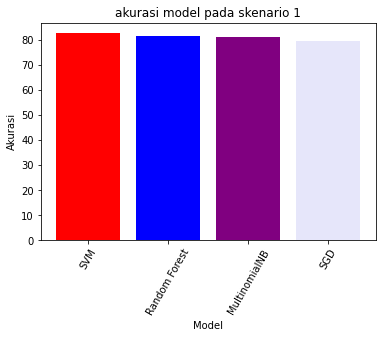

In [ ]:
sk1_sorted_model = sorted(model_for_plot, key=lambda x: x['akurasi'], reverse=True)
model_dict = {}
for a in sk1_sorted_model:
    model_dict[a.get('model name')] = a.get('akurasi')

keys = model_dict.keys()
values = model_dict.values()

plt.bar(keys, values, color=['red', 'blue', 'purple', 'lavender'])
plt.title('akurasi model pada skenario 1')
plt.xlabel('Model')
plt.ylabel('Akurasi')
plt.xticks(rotation=60)
plt.show()

## Skenario 2

***full preprocessing dengan BOW-TFIDF***

### TFIDF Vectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(dfku['clean'])

X_train_temp_vec = tfidf_vectorizer.transform(X_train_temp)
X_test_vec = tfidf_vectorizer.transform(X_test)

### Fit In Model

model yang akan digunakan adalah **MultinomialNB, SVM, SGD, dan RandomForest**

dengan BOW-TFIDF untuk task Binary Classification

dengan scenario k-fold validation pada data training



In [ ]:
model = [{'model_name':'MultinomialNB','instance': MultinomialNB()}, 
         {'model_name':'SVM', 'instance':SVC()},
         {'model_name':'SGD', 'instance':SGDClassifier(class_weight= 'balanced')},
         {'model_name':'Random Forest', 'instance':RandomForestClassifier(class_weight = 'balanced')}
         ]

sk2_val_model = {}

for m in model:
    score = get_score_cv(m['instance'], X_train_temp_vec, Y_train_temp , cv=kfold)
    print('model \t\t: ', m['model_name'])
    print('val score \t:',score['score'])
    print('mean val sore \t:',score['mean'])
    print('\n')

    sk2_val_model[m['model_name']] = score['score'].tolist()

model 		:  MultinomialNB
val score 	: [0.77037037 0.77777778 0.79850746 0.84328358 0.82835821 0.78358209
 0.81343284 0.82835821 0.85074627 0.79850746]
mean val sore 	: 0.8092924267551134


model 		:  SVM
val score 	: [0.82222222 0.78518519 0.85074627 0.82835821 0.85820896 0.80597015
 0.82089552 0.81343284 0.8358209  0.84328358]
mean val sore 	: 0.8264123825317855


model 		:  SGD
val score 	: [0.8        0.77037037 0.79850746 0.82089552 0.8358209  0.76119403
 0.84328358 0.79850746 0.80597015 0.8880597 ]
mean val sore 	: 0.812260917634052


model 		:  Random Forest
val score 	: [0.80740741 0.76296296 0.79850746 0.82835821 0.86567164 0.7761194
 0.79850746 0.79104478 0.80597015 0.81343284]
mean val sore 	: 0.8047982310668879




In [ ]:
sk2_df_val = pd.DataFrame.from_dict(sk2_val_model, orient='index', columns=[f"{i+1} Fold" for i in range(0,kfold)])
sk2_df_val['average'] = sk2_df_val.mean(axis=1)
sk2_df_val

,1 Fold,2 Fold,3 Fold,4 Fold,5 Fold,6 Fold,7 Fold,8 Fold,9 Fold,10 Fold,average
MultinomialNB,0.770370,0.777778,0.798507,0.843284,0.828358,0.783582,0.813433,0.828358,0.850746,0.798507,0.809292
SVM,0.822222,0.785185,0.850746,0.828358,0.858209,0.805970,0.820896,0.813433,0.835821,0.843284,0.826412
SGD,0.800000,0.770370,0.798507,0.820896,0.835821,0.761194,0.843284,0.798507,0.805970,0.888060,0.812261
Random Forest,0.807407,0.762963,0.798507,0.828358,0.865672,0.776119,0.798507,0.791045,0.805970,0.813433,0.804798



### Hyperparameter Tuning

hyperparameter tuning untuk setiap model agar mendapatkan parameter terbaik



#### hyperparameter tuning for MultinomialNB

In [ ]:
mnb_grid_params ={'alpha':[10**x for x in range(-4,4)]}
mnb_alpha_log = [math.log(x,10) for x in mnb_grid_params["alpha"]]

mnb_tuning = GridSearchCV(MultinomialNB(), mnb_grid_params, scoring = 'accuracy', cv=10, n_jobs=-1, return_train_score=True)
mnb_tuning.fit(X_train_temp_vec, Y_train_temp)

print(mnb_tuning.best_estimator_)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


#### hyperparameter tuning for SVM


In [ ]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel': ['linear','rbf','sigmoid']
}

svm_tuning = GridSearchCV(SVC(), svm_param_grid, scoring = 'accuracy', cv=10, n_jobs=-1, return_train_score=True)
svm_tuning.fit(X_train_temp_vec, Y_train_temp)

print(svm_tuning.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


#### hyperparameter tuning for for SGD

In [ ]:
sgd_alpha = [10**x for x in range(-4,4)]
sgd_penalty = ["l1","l2"]
sgd_grid_params ={'alpha':sgd_alpha,'penalty':sgd_penalty}
sgd_alpha_log = [math.log(x,10) for x in sgd_grid_params["alpha"]]

sgd_tuning = GridSearchCV(SGDClassifier(class_weight= 'balanced'), sgd_grid_params, scoring = 'accuracy', cv=10, n_jobs=-1, return_train_score=True)
sgd_tuning.fit(X_train_temp_vec, Y_train_temp)

print(sgd_tuning.best_estimator_)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


#### hyperparameter tuning for RandomForest

In [ ]:
rf_max_depth = [1,5,10,50]
rf_n_estimators = [5,10,100,500]
rf_grid_params ={'max_depth':rf_max_depth,'n_estimators':rf_n_estimators}


rf_tuning = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), rf_grid_params, scoring = 'accuracy', cv=10,n_jobs=-1, return_train_score=True)
rf_tuning.fit(X_train_temp_vec, Y_train_temp)


print(rf_tuning.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


### Final Test Data For Each Model

model yang telah dituning diujikan dengan data test serta di cari nilai akurasinya

In [ ]:
final_model = [
               {'model_name':'MultinomialNB', 'instance':mnb_tuning},
               {'model_name':'SVM', 'instance':svm_tuning},
               {'model_name':'SGD', 'instance':sgd_tuning},
               {'model_name':'Random Forest', 'instance':rf_tuning}
]

sk2_model_for_plot = []

for final in final_model:
    score_final = get_final_score(final['instance'], X_test_vec, Y_test)
    print('model name \t: ', final['model_name'])
    print('akurasi \t: ', score_final)
    print('\n')

    sk2_model_for_plot.append({'model name': f"{final['model_name']}", 'akurasi':np.round(score_final*100,3)})

model name 	:  MultinomialNB
akurasi 	:  0.8003472222222222


model name 	:  SVM
akurasi 	:  0.8402777777777778


model name 	:  SGD
akurasi 	:  0.8055555555555556


model name 	:  Random Forest
akurasi 	:  0.8090277777777778




### Plot Akurasi dari Model Skenario 2

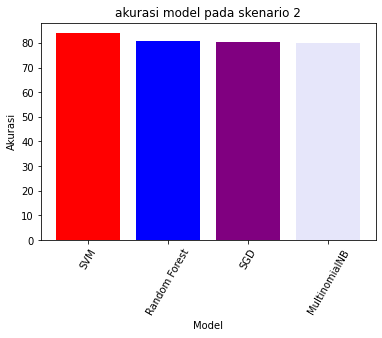

In [ ]:
sk2_sorted_model = sorted(sk2_model_for_plot, key=lambda x: x['akurasi'], reverse=True)
model_dict = {}
for a in sk2_sorted_model:
    model_dict[a.get('model name')] = a.get('akurasi')

keys = model_dict.keys()
values = model_dict.values()

plt.bar(keys, values, color=['red', 'blue', 'purple', 'lavender'])
plt.title('akurasi model pada skenario 2')
plt.xlabel('Model')
plt.ylabel('Akurasi')
plt.xticks(rotation=60)
plt.show()

# Conclusion

dari hasil experiment yang telah dilakukan pada 2 skenario yaitu:

1. skenario 1 (preprocessing + bow-tf)
2. skenario 2 (preprocessing + bow-tfidf)

dengan beberapa classifier seperti **MultinomialNB, SVM, SGD, dan Random Forest** serta menggunakan 10 fold validation pada data training lalu diujikan dengan data test diperoleh bahwa:

performa terbaik terjadi pada **skenario 2** dengan classifier terbaik adalah **SVM** dengan nilai akurasi yang didapatkan sebesar 84.028%

hasil ini menunjukan improvisasi sebesar 2% dari model paper (Prastyo dkk., 2020) dimana model terbaiknya menghasilkan akurasi sebesar 82.00%. 



## Classifier Report

laporan metric evaluasi pada SVM classifier

In [ ]:
svm_score = get_final_score(svm_tuning, X_test_vec, Y_test, all_score=True)
pd.DataFrame(list(svm_score.items()), columns=['metric', 'value'])

,metric,value
0,akurasi,0.840278
1,precision,0.791506
2,recall,0.843621
3,f1,0.816733


## Confusion Matrix

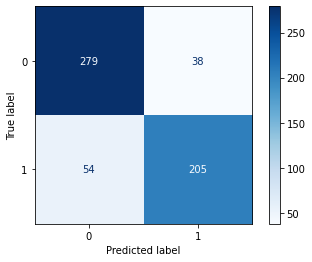

In [ ]:
plot_confusion_matrix(svm_tuning, X_test_vec, Y_test, values_format = '.0f', cmap=plt.cm.Blues)
plt.show()